This file contains python code to compare with sinica paper

It is under the linear setting

Now, I use the same beta from the paper but the PSD as X

In [1]:
import sys
sys.path.append("../../mypkg")

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from numbers import Number

from easydict import EasyDict as edict
from tqdm import trange, tqdm
from scipy.io import loadmat
from pprint import pprint
import itertools
from scipy.stats import chi2


In [3]:
# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

In [4]:
from constants import DATA_ROOT, RES_ROOT, FIG_ROOT, MIDRES_ROOT
from default_paras import def_paras

from hdf_utils.data_gen import gen_covs, gen_simu_psd
from hdf_utils.fns_sinica import coef_fn, fourier_basis_fn, gen_sini_Xthetas
from hdf_utils.likelihood import obt_lin_tm
from hdf_utils.SIS import SIS_linear
from hdf_utils.utils import gen_lam_seq
from hdf_utils.hypo_test import  MS2idxs, obt_test_stat_simple2, obt_test_stat_simple3
from utils.matrix import col_vec_fn, col_vec2mat_fn, conju_grad, svd_inverse, cholesky_inv
from utils.functions import logit_fn
from utils.misc import save_pkl, load_pkl
from splines import obt_bsp_obasis_Rfn, obt_bsp_basis_Rfn_wrapper
from projection import euclidean_proj_l1ball
from optimization.one_step_opt import OneStepOpt
from optimization.cross_validation import CV_err_linear_fn
from optimization.opt import optimization
from optimization.variable_selection import GIC_fn, GCV_fn
from penalties.scad_pen import SCAD
from models.linear_model import LinearModel

from joblib import Parallel, delayed

In [5]:
plt.style.use(FIG_ROOT/"base.mplstyle")
torch.set_default_tensor_type(torch.DoubleTensor)

# Param and fns

## Params

In [6]:
obt_bsp = obt_bsp_obasis_Rfn
#obt_bsp = obt_bsp_basis_Rfn_wrapper
np.random.seed(0)
paras = edict(def_paras.copy())



# Others
paras.num_rep = 200 
paras.init_noise_sd = -1 # the sd of the noise added to the true value for initial values, if -1, make init 0
#paras.SIS_ratio = 1 # the ratio to keep with SIS procedure
paras.SIS_ratio = 0.2 # the ratio to keep with SIS procedure
paras.linear_theta_update="cholesky_inv"

# candidate sets of tuning parameters, only two 
# lambda: penalty term
# N: num of basis
paras.can_lams = [0.01, 0.1, 0.2, 0.3, 0.4, 0.6, 1, 2, 8]
paras.can_lams = [0.01, 0.4, 0.6, 0.8, 1, 1.2, 1.4, 3, 8] # for orthogonal basis
paras.can_Ns = [4, 6, 8, 10, 12]


# generating dataset
paras.n = 500 # num of data obs to be genareted
paras.npts = 100 # num of pts to evaluate X(s)
paras.freqs = np.linspace(2, 45, paras.npts) # freqs
paras.d = 200 # num of ROIs
paras.q = 1 # num of other covariates
paras.sigma2 = 1 # variance of the error
# variance used for estimation, note that the value does not affect any results 
# as long as I tune the parameter properly
paras.norminal_sigma2 = 1 
paras.types_ = ["int"]
paras.is_std = False

# b-spline
paras.x = np.linspace(0, 1, paras.npts)
paras.basis_mats = []
for N in paras.can_Ns:
    paras.basis_mats.append(
        torch.tensor(obt_bsp(paras.x, N, paras.ord)).to(torch.get_default_dtype())
    )

# True parameters
paras.alp_GT = np.array([0])
# fourier basis
cs = [0.0, 0.0, 0.0] # for sinica paper
paras.fourier_basis = fourier_basis_fn(paras.x)[:, :]
paras.fourier_basis_coefs = ([cs[0]*coef_fn(0.2), cs[1]*coef_fn(0.2), cs[2]*coef_fn(0.2)] + 
                             [np.zeros(50)] * (paras.d-3-1) +
                             [coef_fn(0.2)]
                             )
paras.fourier_basis_coefs = np.array(paras.fourier_basis_coefs).T 
paras.beta_GT = paras.fourier_basis @ paras.fourier_basis_coefs
beta_GT_norm = np.linalg.norm(paras.beta_GT, axis=0)
print(beta_GT_norm[beta_GT_norm!=0])

paras.Gam_GT_ests = [(np.linalg.inv(basis_mat.numpy().T 
                                  @ basis_mat.numpy()) 
                                  @ basis_mat.numpy().T 
                                  @ paras.beta_GT) 
                     for basis_mat in paras.basis_mats]

# optimization
# not used, to use it, you have to know GT
Rmins = [(2*(np.linalg.norm(paras.Gam_GT_ests[ix]
                            /np.sqrt(paras.can_Ns[ix]), axis=0).sum() 
           + np.abs(paras.alp_GT).sum())) 
        for ix in range(len(paras.can_Ns))]
paras.Rmin = np.max(Rmins)/5
paras.Rmin = 100000
paras.Rfct = 2
paras.stop_cv = 5e-4
paras.max_iter = 10000
paras.num_cv_fold = 5

# CV
paras.cv_is_center = True
paras.cv_SIS_ratio = 0.2
paras.cv_SIS_pen = 1
paras.cv_SIS_basis_mat = torch.tensor(obt_bsp(paras.x, 6, paras.ord)).to(torch.get_default_dtype())
paras.num_cv_fold = 5
paras.cv_init_noise_sd = -1


# hypothesis test
#without loss of generality, we assume the idxs in M is the first m betas
paras.sel_idx = np.arange(2, paras.d) # M^c set, 
paras.M_idxs = np.delete(np.arange(paras.d), paras.sel_idx) # the M set
paras.Cmats = [
    #np.array([1, -1]).reshape(1, 2), # m x m I matrix, [beta1, beta2] = [0, 0]
    np.eye(len(paras.M_idxs)), # m x m I matrix, [beta1, beta2] = [0, 0]
]
paras.svdinv_eps_Q = 0 # now 0 means inverse, small value like 0.01 means remove small eig vals.
paras.svdinv_eps_Psi = 0


# saving path
paras.save_dir = RES_ROOT/"simu_linear_sinica_samebetaX_tmp"
if not paras.save_dir.exists():
    paras.save_dir.mkdir()

R[write to console]: 
Attaching package: ‘orthogonalsplinebasis’


R[write to console]: The following object is masked from ‘package:stats’:

    integrate




[14.87358566]


## Fns

In [7]:
def _is_exists(tmp_paras):
    """
    Check if a file with the given parameters exists.

    Args:
    tmp_paras:
        d (int): The value of d in the file name.
        n (int): The value of n in the file name.
        npts:
        is_std
        seed (int): The seed value in the file name.

    Returns:
    bool or Path: Returns the file path if the file exists, otherwise returns False.
    """
    _get_n = lambda fil: int(fil.stem.split("_")[2].split("-")[-1])
    fils = MIDRES_ROOT.glob(f"PSD_d-{tmp_paras.d}_n-*npts-{tmp_paras.npts}_is_std-{tmp_paras.is_std}")
    # We do not need fil with n as we know the data with corresponding seed does not exist
    fils = [fil for fil in fils if _get_n(fil) !=tmp_paras.n]
    if len(fils) == 0:
        return False
    else:
        fils = sorted(fils, key=_get_n)
        ns = np.array([_get_n(fil) for fil in fils])
        idxs = np.where(tmp_paras.n <= ns)[0]
        if len(idxs) == 0:
            return False
        else:
            fil =fils[idxs[0]]
            path = MIDRES_ROOT/fil/f"seed_{tmp_paras.seed}.pkl"
            return path if path.exists() else False
def _get_filename(params):
    keys = ["d", "n", "npts", "is_std"]
    folder_name = 'PSD_'+'_'.join(f"{k}-{params[k]}" for k in keys)
    return folder_name + f'/seed_{params.seed}.pkl'
def _gen_simu_data_all(seed, paras, verbose=False, is_gen=False):
    """
    Generate simulated data for all parameters.

    Args:
        seed (int): Seed for random number generator.
        paras (dict): Dictionary containing the following parameters:
            - n (int): Number of samples.
            - d (int): Number of dimensions.
            - q (int): Number of covariates.
            - types_ (list): List of types for generating covariates.
            - alp_GT (list): List of ground truth alpha values.
            - beta_GT (list): List of ground truth beta values.
            - freqs (list): List of frequencies for generating simulated PSD.
            - sigma2 (float): Variance of the noise.
        verbose(bool): Verbose or not
        is_gen(bool): Only for generating or not. If True, only checking or generating X, not return anything.

    Returns:
        all_data (dict): Dictionary containing the following simulated data:
            - X (torch.Tensor): Tensor of shape (n, d, npts) containing the simulated PSD.
            - Y (torch.Tensor): Tensor of shape (n,) containing the response variable.
            - Z (torch.Tensor): Tensor of shape (n, q) containing the covariates.
    """
    np.random.seed(seed)
    _paras = edict(paras.copy())
    # simulated PSD
    assert len(_paras.types_) == _paras.q
    assert len(_paras.alp_GT) == _paras.q
    tmp_paras = edict()
    tmp_paras.seed = seed 
    tmp_paras.n = _paras.n
    tmp_paras.d = _paras.d
    tmp_paras.npts = _paras.npts
    tmp_paras.is_std = _paras.is_std
    
    file_path = MIDRES_ROOT/_get_filename(tmp_paras)
    if file_path.exists():
        if is_gen:
            return None
        simu_curvs = load_pkl(file_path, verbose=verbose)
    else:
        ofil =  _is_exists(tmp_paras)
        if ofil:
            if is_gen:
                return None
            simu_curvs = load_pkl(ofil, verbose=verbose)
        else:
            if _paras.is_std:
                simu_curvs = gen_simu_psd(_paras.n, _paras.d, _paras.freqs, prior_sd=10, n_jobs=28, is_prog=False, is_std=_paras.is_std)
            else:
                simu_curvs = gen_simu_psd(_paras.n, _paras.d, _paras.freqs, prior_sd=10, n_jobs=28, is_prog=False, is_std=_paras.is_std)
                simu_curvs = simu_curvs - simu_curvs.mean(axis=-1, keepdims=True); # not std, but center it
            save_pkl(file_path, simu_curvs, verbose=verbose)
    if is_gen:
        return None
    simu_curvs = simu_curvs[:_paras.n]
    simu_curvs = (simu_curvs + np.random.randn(*simu_curvs.shape)*5)*1 # larger
    #simu_curvs = np.random.randn(_paras.n, _paras.d, _paras.npts)* 10
    simu_covs = gen_covs(_paras.n, _paras.types_)
    
    # linear term and Y
    int_part = np.sum(_paras.beta_GT.T* simu_curvs[:, :, :], axis=1).mean(axis=1)
    cov_part = simu_covs @ _paras.alp_GT 
    
    # linear term
    lin_term = cov_part + int_part
    
    # Y 
    #errs_raw = np.random.standard_t(df=3, size=paras.n)                                                                                                                                                   
    #errs = np.sqrt(_paras.sigma2)*(errs_raw - errs_raw.mean())/errs_raw.std()
    #Y = lin_term + errs
    Y = lin_term + np.random.randn(_paras.n)*np.sqrt(_paras.sigma2)
    
    # center
    X_centered = simu_curvs - simu_curvs.mean(axis=0, keepdims=True)
    Y_centered = Y - Y.mean(axis=0, keepdims=True)
    
    # To torch
    X = torch.Tensor(X_centered) # n x d x npts
    Z = torch.Tensor(simu_covs) # n x q
    Y = torch.Tensor(Y_centered)
    
    all_data = edict()
    all_data.X = X
    all_data.Y = Y
    all_data.Z = Z
    all_data.lin_term = lin_term
    return all_data


In [8]:
data = _gen_simu_data_all(1, paras, verbose=True);

Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_cmp2sinica/../../mypkg/../mid_results/PSD_d-200_n-500_npts-100_is_std-False/seed_1.pkl


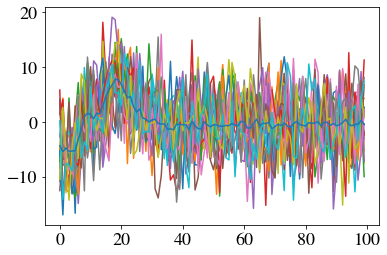

In [9]:
idx = 0
for ix in range(20):
    plt.plot(data.X[idx, ix, :])
plt.plot(data.X[idx, :, :].mean(axis=0))
#plt.plot(data.X[idx, 0, :])
#plt.plot(data.X[idx, 1, :])

# Simu

## SIS check (just for check)

In [10]:
def _SIS_fn(seed, SIS_ratio, ridge_pen, N, paras):
    torch.set_default_tensor_type(torch.DoubleTensor)
    np.random.seed(seed)
    torch.manual_seed(seed)
        
    _paras = edict(paras.copy())
    _paras.seed = seed
    _paras.N = N
    _paras.basis_mat = _paras.basis_mats[_paras.can_Ns.index(N)]
    cur_data = _gen_simu_data_all(_paras.seed, _paras)
    
    # do sure independent screening for dim reduction
    if SIS_ratio < 1:
        keep_idxs, _  = SIS_linear(cur_data.Y, cur_data.X, cur_data.Z, _paras.basis_mat, SIS_ratio, _paras, ridge_pen=ridge_pen)
    else:
        keep_idxs = _paras.sel_idx
    M_idxs = np.delete(np.arange(_paras.d), _paras.sel_idx)
    _paras.keep_idxs = np.sort(np.concatenate([M_idxs, keep_idxs]))
    return _paras.keep_idxs

In [11]:
num_rep = 200
with Parallel(n_jobs=20) as parallel:
    keep_idxss = parallel(delayed(_SIS_fn)(seed, 0.2, ridge_pen=1, N=6, paras=paras) for seed in 
                          tqdm(range(num_rep), total=num_rep))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [02:21<00:00,  1.41it/s]


Text(0.5, 1.0, '[1.]')

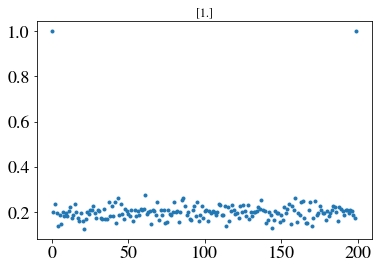

In [12]:
vs, cts = np.unique(np.concatenate(keep_idxss), return_counts=1);
cts = cts[np.argsort(vs)]/len(keep_idxss)
vs = np.sort(vs);
plt.plot(vs, cts, ".")
plt.title(f"{cts[vs >198]}")

## Simulation

In [9]:
def _run_fn(seed, lam, N, paras, is_save=False, is_cv=False, verbose=False):
    """Now (on Aug 25, 2023), if we keep seed the same, the cur_data is the same. 
       If you want to make any changes, make sure this. 
    """
    torch.set_default_tensor_type(torch.DoubleTensor)
    np.random.seed(seed)
    torch.manual_seed(seed)
        
    _paras = edict(paras.copy())
    _paras.Rv = _paras.Rfct * _paras.Rmin
    _paras.seed = seed
    _paras.lam = lam
    _paras.N = N
    _paras.basis_mat = _paras.basis_mats[_paras.can_Ns.index(N)]
    _paras.Gam_GT_est = paras.Gam_GT_ests[_paras.can_Ns.index(N)]
    cur_data = _gen_simu_data_all(_paras.seed, _paras)
    
    f_name = f"seed_{seed:.0f}-lam_{lam*1000:.0f}-N_{N:.0f}-c1_{cs[0]*1000:.0f}_est.pkl"
    
    
    res = edict()
    if not (_paras.save_dir/f_name).exists():
        # do sure independent screening for dim reduction
        if _paras.SIS_ratio < 1:
            keep_idxs, _  = SIS_linear(cur_data.Y, cur_data.X, cur_data.Z, _paras.basis_mats[_paras.can_Ns.index(6)],
                                       _paras.SIS_ratio, _paras, ridge_pen=1)
        else:
            keep_idxs = _paras.sel_idx
        M_idxs = np.delete(np.arange(_paras.d), _paras.sel_idx)
        _paras.keep_idxs = np.sort(np.concatenate([M_idxs, keep_idxs]))
            
        _paras.sel_idx_SIS = np.where(np.array([keep_idx in _paras.sel_idx for keep_idx in _paras.keep_idxs]))[0]
        _paras.d_SIS = len(_paras.keep_idxs)
        
        cur_data_SIS = edict(cur_data.copy())
        cur_data_SIS.X = cur_data.X[:, _paras.keep_idxs, :]
        
        
        if _paras.init_noise_sd < 0:
            alp_init = torch.zeros(_paras.q)
            Gam_init = torch.zeros(_paras.N, _paras.d_SIS)
            theta_init = torch.cat([alp_init, col_vec_fn(Gam_init)/np.sqrt(_paras.N)])
            rhok_init = torch.zeros(_paras.d_SIS*_paras.N)
        else:
            alp_init = torch.Tensor(_paras.alp_GT) + torch.randn(_paras.q)*_paras.init_noise_sd
            Gam_init = torch.Tensor(_paras.Gam_GT_est[:, _paras.keep_idxs]) + torch.randn(_paras.N, _paras.d_SIS)*_paras.init_noise_sd
            theta_init = torch.cat([alp_init, col_vec_fn(Gam_init)/np.sqrt(_paras.N)])
            rhok_init = torch.randn(_paras.d_SIS*_paras.N)
            
        model = LinearModel(Y=cur_data_SIS.Y, 
                            X=cur_data_SIS.X, 
                            Z=cur_data_SIS.Z, 
                            basis_mat=_paras.basis_mat, 
                            sigma2=_paras.norminal_sigma2)
                            #sigma2=_paras.sigma2)
        # 3e0
        pen = SCAD(lams=_paras.lam, a=_paras.a,  sel_idx=_paras.sel_idx_SIS)
            
        
        main_res = optimization(model=model, 
                                penalty=pen, 
                                inits=[alp_init, Gam_init, theta_init, rhok_init],
                                is_prg=verbose,
                                save_paras=False,    
                                input_paras=_paras)
        opt = main_res[0]
        est_Gam = opt.Gamk
        est_alp = opt.alpk
        Q_mat = -model.log_lik_der2(est_alp, est_Gam)
        model.log_lik_der1(est_alp, est_Gam);
        Sig_mat = (model.log_lik_der1_vs.unsqueeze(-1) * model.log_lik_der1_vs.unsqueeze(1)).mean(axis=0) 
        est_theta = torch.cat([est_alp, col_vec_fn(est_Gam)/np.sqrt(_paras.N)])
        nonzero_idxs = torch.nonzero(torch.norm(est_Gam, dim=0)).reshape(-1).numpy()
        MS_unions = np.sort(np.union1d(_paras.M_idxs, nonzero_idxs))
        keep_idxs_test = MS2idxs(_paras.q, _paras.N, MS_unions)
        Q_mat_part = Q_mat[keep_idxs_test][:, keep_idxs_test]
        Sig_mat_part = Sig_mat[keep_idxs_test][:, keep_idxs_test]
        
        res = edict()
        _paras.Gam_GT_ests = None
        _paras.basis_mats = None
        _paras.fourier_basis_coefs = None
        _paras.fourier_basis = None
        res._paras = _paras
        res.est_sigma2 = torch.mean((model.Y - model._obt_lin_tm(est_alp, est_Gam))**2)
        res.Sig_mat_part = Sig_mat_part
        res.Q_mat_part = Q_mat_part
        res.est_Gam = est_Gam
        res.est_alp = est_alp
        res.conv_num = main_res[1]
        #res.cur_data = cur_data
        #res.model = model
        res.keep_idxs = keep_idxs
        res.AIC = GIC_fn(res, "AIC")
        res.BIC = GIC_fn(res, "BIC")
        res.GCV = GCV_fn(res)
    
        if is_cv:
            cv_errs = CV_err_linear_fn(data=cur_data, 
                                       num_cv_fold=_paras.num_cv_fold,
                                       is_prg=verbose, 
                                       save_paras=False,    
                                       input_paras=_paras)
            
            res.cv_errs = cv_errs
        else:
            res.cv_errs = None
        if is_save:
            save_pkl(_paras.save_dir/f_name, res, verbose=verbose)
    return res


In [17]:
from hdf_utils.hypo_test import get_Amat
def obt_test_stat_simple2(Q_mat_part, Sig_mat_part, est_alp, est_Gam, Cmat, paras):
    """
    Obtain the test statistics via the estimator, even simpler than simple 

    Args:
        Q_mat_part: Second der of model
        Sig_mat_part: first der 
        est_alp: Estimated alp parameters
        est_Gam: Estimated Gam parameters
        Cmat: Hypothesis mat, r x m
        paras: Dictionary containing parameters for the test
            - N: Number of samples
            - M_idxs: Indices of the M set
            - q: Number of ROIs
            - svdinv_eps_Q: Threshold for inverse of Q matrix
            - svdinv_eps_Psi: Threshold for inverse of Psi matrix
            - n: Number of observations

    Returns:
        T_v: Test statistic value
    """
    _paras = edict(paras.copy())
    est_theta = torch.cat([est_alp, col_vec_fn(est_Gam)/np.sqrt(_paras.N)])
    
    # obtain the idxs to keep for test
    nonzero_idxs = torch.nonzero(torch.norm(est_Gam, dim=0)).reshape(-1).numpy()
    MS_unions = np.sort(np.union1d(_paras.M_idxs, nonzero_idxs))
    keep_idxs_test = MS2idxs(_paras.q, _paras.N, MS_unions)
    
    # A mat
    k = len(np.setdiff1d(nonzero_idxs, _paras.M_idxs))
    Amat = torch.Tensor(get_Amat(k, Cmat, _paras))
    
    # calculate Test stats
    Q_mat_part_inv = torch.linalg.pinv(Q_mat_part, hermitian=True, rtol=_paras.svdinv_eps_Q)
    Psi = Amat @ Q_mat_part_inv @ Sig_mat_part @ Q_mat_part_inv @ Amat.T
    Psi_inv = torch.linalg.pinv(Psi, hermitian=True, rtol=_paras.svdinv_eps_Psi)
    global Psi0
    Psi0 = Psi
    
    T_p1 = Amat @ est_theta[keep_idxs_test]
    T_v = T_p1 @ Psi_inv @ T_p1 * _paras.n 
    return T_v

In [18]:
def obt_test_stat_simple3(est_sigma2, Q_mat_part, est_alp, est_Gam, Cmat, paras):
    """
    Obtain the test statistics via the estimator, even simpler than simple 

    Args:
        Q_mat_part: Second der of model
        est_alp: Estimated alp parameters
        est_Gam: Estimated Gam parameters
        Cmat: Hypothesis mat, r x m
        paras: Dictionary containing parameters for the test
            - N: Number of samples
            - M_idxs: Indices of the M set
            - q: Number of ROIs
            - svdinv_eps_Q: Threshold for inverse of Q matrix
            - svdinv_eps_Psi: Threshold for inverse of Psi matrix
            - n: Number of observations

    Returns:
        T_v: Test statistic value
    """
    _paras = edict(paras.copy())
    est_theta = torch.cat([est_alp, col_vec_fn(est_Gam)/np.sqrt(_paras.N)])
    
    # obtain the idxs to keep for test
    nonzero_idxs = torch.nonzero(torch.norm(est_Gam, dim=0)).reshape(-1).numpy()
    MS_unions = np.sort(np.union1d(_paras.M_idxs, nonzero_idxs))
    keep_idxs_test = MS2idxs(_paras.q, _paras.N, MS_unions)
    
    # A mat
    k = len(np.setdiff1d(nonzero_idxs, _paras.M_idxs))
    Amat = torch.Tensor(get_Amat(k, Cmat, _paras))
    
    # calculate Test stats
    Q_mat_part_inv = torch.linalg.pinv(Q_mat_part, hermitian=True, rtol=_paras.svdinv_eps_Q)
    Psi = est_sigma2*Amat @ Q_mat_part_inv @ Amat.T/_paras.norminal_sigma2
    Psi_inv = torch.linalg.pinv(Psi, hermitian=True, rtol=_paras.svdinv_eps_Psi)
    global Psi1
    Psi1 = Psi
    
    T_p1 = Amat @ est_theta[keep_idxs_test]
    T_v = T_p1 @ Psi_inv @ T_p1 * _paras.n 
    return T_v

In [10]:
def _test_fn(Cmat, est_res, svdinv_eps_Q=0, svdinv_eps_Psi=0, 
             is_save=False, verbose=False):
    torch.set_default_tensor_type(torch.DoubleTensor)
    _paras = est_res._paras
    _paras.svdinv_eps_Q = svdinv_eps_Q
    _paras.svdinv_eps_Psi = svdinv_eps_Psi
    f_name = f"seed_{_paras.seed:.0f}-lam_{_paras.lam*1000:.0f}-N_{_paras.N:.0f}_test_stat.pkl"
    
    T_v = obt_test_stat_simple2(Q_mat_part=est_res.Q_mat_part, 
                               Sig_mat_part=est_res.Sig_mat_part,
                               est_alp=est_res.est_alp, 
                               est_Gam=est_res.est_Gam,
                               Cmat=Cmat,
                               paras=_paras,
                               ).item() 
    pval = chi2.sf(T_v, Cmat.shape[0]*_paras.N)
    
    res = edict()
    res.T_v = T_v
    res.pval = pval
    res.Cmat = Cmat
    if is_save:
        save_pkl(_paras.save_dir/f_name, res, verbose=verbose)
    return res

In [11]:
def _test_fn1(Cmat, est_res, svdinv_eps_Q=0, svdinv_eps_Psi=0, 
             is_save=False, verbose=False):
    torch.set_default_tensor_type(torch.DoubleTensor)
    _paras = est_res._paras
    _paras.svdinv_eps_Q = svdinv_eps_Q
    _paras.svdinv_eps_Psi = svdinv_eps_Psi
    f_name = f"seed_{_paras.seed:.0f}-lam_{_paras.lam*1000:.0f}-N_{_paras.N:.0f}_test_stat.pkl"
    
    T_v = obt_test_stat_simple3(est_sigma2=est_res.est_sigma2,
                               Q_mat_part=est_res.Q_mat_part, 
                               est_alp=est_res.est_alp, 
                               est_Gam=est_res.est_Gam,
                               Cmat=Cmat,
                               paras=_paras,
                               ).item() 
    pval = chi2.sf(T_v, Cmat.shape[0]*_paras.N)
    
    res = edict()
    res.T_v = T_v
    res.pval = pval
    res.Cmat = Cmat
    if is_save:
        save_pkl(_paras.save_dir/f_name, res, verbose=verbose)
    return res

### single test

In [18]:
seed = 5
lam = 0.30
N = 6 
res = _run_fn(seed, lam, N, paras,verbose=True, is_save=0, is_cv=0);
paras.svdinv_eps_Q = 1e-6
paras.svdinv_eps_Psi = 1e-6;
test_res = _test_fn(paras.Cmats[0], res, 
                    svdinv_eps_Q=paras.svdinv_eps_Q, svdinv_eps_Psi=paras.svdinv_eps_Psi);
test_res1 = _test_fn1(paras.Cmats[0], res, 
                    svdinv_eps_Q=paras.svdinv_eps_Q, svdinv_eps_Psi=paras.svdinv_eps_Psi);
test_res, test_res1

  1%|▉                                                                                                 | 91/10000 [00:00<00:19, 499.97it/s, error=0.000503, GamL0=4, CV=0.0005]


({'T_v': 7.396456022293995,
  'pval': 0.28573311335634355,
  'Cmat': array([[1.]])},
 {'T_v': 6.513349873710608, 'pval': 0.3682015546089928, 'Cmat': array([[1.]])})

In [20]:
Psi0.shape

torch.Size([6, 6])

In [21]:
torch.svd(Psi0).S

tensor([10.4628,  8.3385,  8.0842,  5.7405,  4.7425,  3.4754])

In [22]:
torch.svd(Psi1).S

tensor([13.1718,  9.8498,  8.0101,  6.8719,  5.2471,  4.1285])

In [23]:
torch.svd(res.Q_mat_part).S

tensor([5.0764e+02, 1.6096e+02, 2.0163e+01, 1.3945e+01, 5.8890e+00, 2.2157e+00,
        1.7424e+00, 1.6542e+00, 1.5121e+00, 1.3912e+00, 1.2719e+00, 1.2110e+00,
        1.1905e+00, 1.1096e+00, 1.0872e+00, 1.0267e+00, 1.0000e+00, 9.8166e-01,
        9.6904e-01, 8.8453e-01, 8.5911e-01, 8.2601e-01, 7.3433e-01, 7.1722e-01,
        6.9824e-01, 6.8193e-01, 6.2280e-01, 5.9596e-01, 5.6996e-01, 5.4988e-01,
        5.2925e-01, 5.1365e-01, 4.8635e-01, 4.5069e-01, 4.1569e-01, 3.8358e-01,
        3.5341e-01, 3.4694e-01, 3.2186e-01, 3.1411e-01, 2.7730e-01, 2.7052e-01,
        2.3455e-01, 2.2242e-01, 2.1734e-01, 2.0335e-01, 1.9913e-01, 1.8417e-01,
        1.7043e-01, 1.5422e-01, 1.4867e-01, 1.3888e-01, 1.2395e-01, 1.0874e-01,
        9.3884e-02, 8.8066e-02, 7.9243e-02, 6.7308e-02, 5.8674e-02, 5.1434e-02,
        4.0141e-02])

In [152]:
#torch.mean((res.model.Y - res.model._obt_lin_tm(res.est_alp, res.est_Gam))**2)
torch.linalg.norm(res.est_Gam, axis=0)

tensor([0.7027, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0810, 0.0000,
        0.0000, 0.0744, 0.0980, 0.0000, 0.0000, 0.1288, 0.2059, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0207, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.1197, 0.0000, 0.0053, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000])

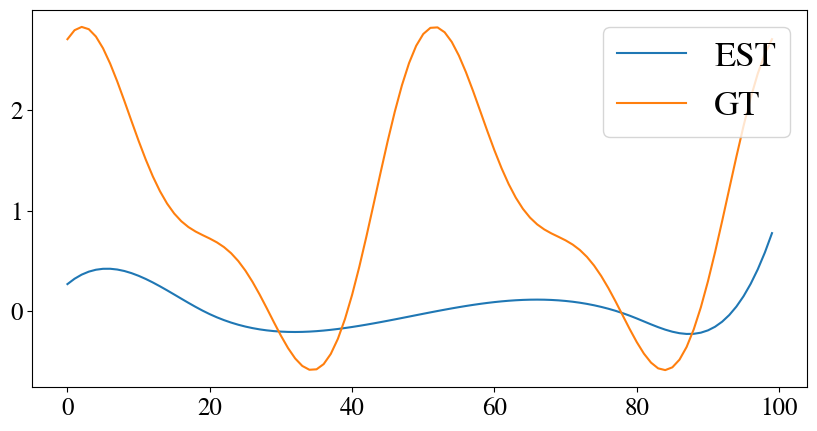

In [74]:
est_beta = res._paras.basis_mat @ res.est_Gam
gt_beta = res._paras.beta_GT[:, res._paras.keep_idxs]
idx = -1
plt.plot(est_beta[:, idx], label="EST")
plt.plot(gt_beta[:, idx], label="GT")
plt.legend()

### Multipe test

In [ ]:
seed = 12
N = 8
# orthbasis
# N, lam
# 4: 0.2, 0.05, 0.5
# can_lams = [0.001, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.50, 2]
#paras.alpha = 0.9
#paras.beta = 1
#paras.a = 3.7
def _run_fn1(seed):
    lam = 0.25
    Cmat = paras.Cmats[0]
    res = _run_fn(seed, lam, N, paras, verbose=False, is_save=0, is_cv=0);
    test_res = _test_fn1(Cmat, res, svdinv_eps_Q=1e-7, svdinv_eps_Psi=1e-7);
    test_res.L0 = torch.sum(torch.linalg.norm(res.est_Gam, axis=0)!=0).item()
    test_res.AIC = res.AIC
    test_res.BIC = res.BIC
    test_res.GCV = res.GCV
    test_res.est_sigma2 = res.est_sigma2
    return test_res
    
num_rep = 1000
with Parallel(n_jobs=20) as parallel:
    test_ress = parallel(delayed(_run_fn1)(seed) for seed in tqdm(range(num_rep), total=num_rep))
    

 68%|███████████████████████████████████████████████████████████████████████████████████████████▊                                           | 680/1000 [05:57<03:47,  1.41it/s]

In [19]:
pvals = np.array([res.pval for res in test_ress])
T_vs = np.array([res.T_v for res in test_ress]);
L0s = np.array([res.L0 for res in test_ress]);
AICs = np.array([res.AIC for res in test_ress]);
BICs = np.array([res.BIC for res in test_ress]);
GCVs = np.array([res.GCV for res in test_ress]);
est_sigma2s = np.array([res.est_sigma2 for res in test_ress]);
chi_df = paras.Cmats[0].shape[0]*N
print(
    f"The size is {np.mean(pvals<0.05):.3f} and "
    f"the mean of Tv is {np.mean(T_vs):.3f} and thoeretically it is {chi_df:.0f}. "
    f"L0 is {np.mean(L0s):.2f}."
     )
print(
    f"AIC is {np.mean(AICs):.2f}. "
    f"BIC is {np.mean(BICs):.2f}. "
    f"GCV is {np.mean(GCVs):.2f}. \n"
    f"est_sigma2 is {np.mean(est_sigma2s):.5f}. "
     )

The size is 0.023 and the mean of Tv is 14.131 and thoeretically it is 16. L0 is 11.19.
AIC is 0.32. BIC is 1.09. GCV is 1.45. 
est_sigma2 is 0.95906. 


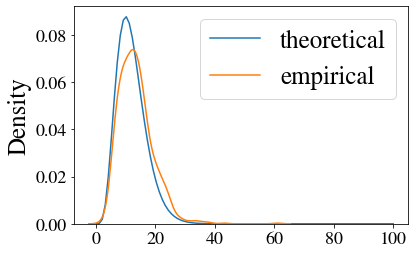

In [17]:
chi_df = paras.Cmats[0].shape[0]*N
xs = np.linspace(0.1, 100, 100)
theo_curvs_log = chi2.logpdf(xs, chi_df);
plt.plot(xs, np.exp(theo_curvs_log) , label="theoretical")
sns.kdeplot(T_vs, label="empirical")
plt.legend()